# Integrating Multi-Frequency Trading Signals for Optimal Market Timing A Machine Learning Approach


### 1. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

import shap


#### 1.1 Load Data

In [2]:
def data_assemble(ticker, timestamps):
    # Load the data
    file_path = f'data/{ticker}_intraday-8min_historical-data-05-05-2024.csv'
    option_file_path = f'data/{ticker}_options-overview-history-05-05-2024.csv'
    
    # Load the price data
    data = pd.read_csv(file_path)
    data = data.drop(data.index[-1])
    data = data.iloc[::-1].reset_index(drop=True)
    
    # Load the option data 
    option_data = pd.read_csv(option_file_path)
    option_data = option_data.drop(option_data.index[-1])
    option_data = option_data.iloc[::-1].reset_index(drop=True)
    
    # Change the data type of 'Date' and set it as index
    option_data['Date'] = pd.to_datetime(option_data['Date'])
    option_data['Date'] = option_data['Date'].dt.date
    option_data.set_index('Date', inplace=True)
    
    # Change the data type of '1D IV Chg' to float
    option_data['1D IV Chg'] = option_data['1D IV Chg'].str.replace('%', '', regex=True).astype(float)
    
    # Combine two dataset
    deliver_data = pd.DataFrame()
    
    deliver_data[f'{ticker}_1D_IV_Chg'] = option_data['1D IV Chg']
    deliver_data[f'{ticker}_P/C_Volume'] = option_data['P/C Vol']
    deliver_data[f'{ticker}_P/C_OI'] = option_data['P/C OI']

    # Extract features from price-volume data
    for timestamp in timestamps:
        
        data_filtered = data[data['Time'].str.endswith(timestamp)]
        data_filtered = data_filtered.copy()
        data_filtered['Time'] = pd.to_datetime(data_filtered['Time'])
        
        # Extract date only for grouping
        data_filtered['Date'] = data_filtered['Time'].dt.date
        
        # Change the data type of '%Chg' to float
        data_filtered['%Chg'] = data_filtered['%Chg'].str.replace('%', '', regex=True).astype(float)
        
        # Copy the filtered DataFrame to avoid SettingWithCopyWarning in future operations
        data_filtered_safe = data_filtered.copy()
        data_filtered_safe.set_index('Date', inplace=True)
        
        # Calculate the rolling mean and standard deviation with a window of 7 days the reversed DataFrame
        rolling_mean = data_filtered_safe['Volume'].rolling(window=7).mean()
        rolling_std = data_filtered_safe['Volume'].rolling(window=7).std()
        
        # Use .loc to safely create the new standardized column on the reversed DataFrame
        data_filtered_safe.loc[:, 'Volume_Rolling_Standardized'] = (data_filtered_safe['Volume'] - rolling_mean) / rolling_std
        
        deliver_data[f'{ticker}_PCVRS_{timestamp}'] = data_filtered_safe['%Chg']* data_filtered_safe['Volume_Rolling_Standardized'].shift(-1)
        
    return deliver_data  

In [3]:
tickers = ['arm', 'nvda', 'tsm', 'smci','mu', 'tsla', 'amd']

timestamps = ['04:00','08:00','08:24','08:32', '09:28', '09:36']
raw_data = pd.DataFrame()

for ticker in tickers:
    deliver_data = data_assemble(ticker, timestamps)
    raw_data = pd.concat([raw_data, deliver_data], axis = 1)

In [4]:
raw_data

,arm_1D_IV_Chg,arm_P/C_Volume,arm_P/C_OI,arm_PCVRS_04:00,arm_PCVRS_08:00,arm_PCVRS_08:24,arm_PCVRS_08:32,arm_PCVRS_09:28,arm_PCVRS_09:36,nvda_1D_IV_Chg,...,tsla_PCVRS_09:36,amd_1D_IV_Chg,amd_P/C_Volume,amd_P/C_OI,amd_PCVRS_04:00,amd_PCVRS_08:00,amd_PCVRS_08:24,amd_PCVRS_08:32,amd_PCVRS_09:28,amd_PCVRS_09:36
Date,,,,,,,,,,,,,,,,,,,,,
2023-09-25,0.51,1.132468,1.516387,NaN,NaN,NaN,NaN,NaN,NaN,0.81,...,NaN,0.66,0.546959,1.090203,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-26,-2.11,0.822656,1.448749,NaN,NaN,NaN,NaN,NaN,NaN,1.79,...,NaN,2.11,0.809337,1.089693,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-27,-5.77,1.175687,1.313645,NaN,NaN,NaN,NaN,NaN,NaN,-2.22,...,NaN,-1.59,0.777067,1.063284,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-28,0.81,0.462860,1.257175,NaN,NaN,NaN,NaN,NaN,NaN,-0.59,...,NaN,2.29,0.943761,1.070267,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-29,-0.92,0.893335,1.138045,NaN,NaN,NaN,NaN,NaN,NaN,-1.98,...,NaN,0.00,0.787385,1.074250,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29,-0.58,0.677483,0.847003,-2.112966,-0.456332,-0.035603,0.219291,0.862560,2.191269,-0.51,...,0.404969,1.07,0.480020,1.009012,-0.252106,-0.086154,-0.284058,0.259607,-0.390979,-1.046881
2024-04-30,0.93,1.017327,0.844675,0.524902,0.183253,0.027154,0.461938,-1.434069,-0.132875,0.18,...,-1.124674,-0.27,0.509456,0.990507,-0.386183,0.591185,-0.587266,0.186524,-0.662431,-1.525235
2024-05-01,-2.81,1.799032,0.850917,0.784209,-0.457898,0.007919,0.143741,0.110602,-0.072363,-1.21,...,0.823413,-11.31,0.844753,0.939306,-0.343294,-0.099809,0.616743,-0.196600,0.368616,-0.093453


#### 1.2 Dealing with Missing Values

In [5]:
# Handling missing value because of rolling window of 7 days and the incomplete data of the last day
data = raw_data.iloc[7:-1]

In [6]:
# delete 4:00 data for small cap firms ('arm','tsm', 'smci','mu' )
columns_to_delete = ['arm_PCVRS_04:00','tsm_PCVRS_04:00','smci_PCVRS_04:00','mu_PCVRS_04:00']
data = data.drop(columns=columns_to_delete)

In [7]:
print(f'Number of missing values: {data.isna().sum().sum()}')
print(f'Columns with missing values:\n {data.columns[data.isna().any()]}')

Number of missing values: 95
Columns with missing values:
 Index(['arm_PCVRS_08:00', 'arm_PCVRS_08:24', 'arm_PCVRS_08:32',
       'tsm_PCVRS_08:24', 'tsm_PCVRS_08:32', 'smci_PCVRS_08:24',
       'smci_PCVRS_08:32', 'mu_PCVRS_08:24', 'mu_PCVRS_08:32'],
      dtype='object')


In [8]:
# Handling missing value with mean of 4 nearest days
def fill_missing_with_mean(df, column):
    filled_column = df[column].copy()
    for i in range(len(filled_column)):
        if pd.isnull(filled_column.iloc[i]):
            start = max(i - 2, 0)
            end = min(i + 3, len(filled_column))
            surrounding_values = filled_column.iloc[start:end]
            mean_value = surrounding_values.mean()
            df.loc[df.index[i], column] = mean_value
    return df


In [9]:
# Apply the function to the columns with missing values
for column in data.columns:
    if data[column].isnull().any():
        data = fill_missing_with_mean(data, column)

In [10]:
data

,arm_1D_IV_Chg,arm_P/C_Volume,arm_P/C_OI,arm_PCVRS_08:00,arm_PCVRS_08:24,arm_PCVRS_08:32,arm_PCVRS_09:28,arm_PCVRS_09:36,nvda_1D_IV_Chg,nvda_P/C_Volume,...,tsla_PCVRS_09:36,amd_1D_IV_Chg,amd_P/C_Volume,amd_P/C_OI,amd_PCVRS_04:00,amd_PCVRS_08:00,amd_PCVRS_08:24,amd_PCVRS_08:32,amd_PCVRS_09:28,amd_PCVRS_09:36
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-04,-2.71,0.821674,1.130102,-0.163840,0.076881,0.000000,0.491266,-0.559190,-1.01,0.854788,...,0.017711,-1.47,0.676013,1.064567,0.609188,-0.004842,-0.020263,0.047309,0.271678,-0.098322
2023-10-05,-0.26,1.048847,1.143303,0.042519,-0.013171,-0.425447,1.527575,0.840652,-1.44,0.907497,...,-0.303305,1.03,0.698748,1.079848,0.088548,0.049993,-0.249294,-0.424809,-0.997257,-0.399870
2023-10-06,-2.19,0.656871,1.129143,-0.191443,-0.549035,0.009750,0.005099,-1.304684,-1.73,0.919452,...,0.984738,-1.44,0.757578,1.065501,-0.034046,-0.033183,1.134102,0.059561,-0.778724,0.700302
2023-10-09,2.54,0.408544,1.286995,-0.781800,-0.301732,0.263161,-0.237996,-0.592160,1.16,0.791038,...,0.248793,1.05,0.760729,1.068228,0.849811,-0.034062,-0.106394,0.246536,-1.044791,0.564209
2023-10-10,2.71,0.683767,1.198154,0.137347,-0.007592,-0.005503,-2.118345,-0.009139,-1.29,0.754786,...,-0.677498,-0.52,0.365551,1.063996,-0.006577,-0.010604,-0.023741,0.072217,-0.258721,-0.333052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,-1.32,0.609657,0.908549,-0.660650,-0.566136,-0.454138,2.756313,0.523968,1.71,0.594236,...,0.785742,0.04,0.488770,0.965973,-0.072012,-0.019463,-0.105867,0.311090,-0.014705,-0.175140
2024-04-29,-0.58,0.677483,0.847003,-0.456332,-0.035603,0.219291,0.862560,2.191269,-0.51,0.569648,...,0.404969,1.07,0.480020,1.009012,-0.252106,-0.086154,-0.284058,0.259607,-0.390979,-1.046881
2024-04-30,0.93,1.017327,0.844675,0.183253,0.027154,0.461938,-1.434069,-0.132875,0.18,0.611931,...,-1.124674,-0.27,0.509456,0.990507,-0.386183,0.591185,-0.587266,0.186524,-0.662431,-1.525235


In [11]:
print(f'Number of missing values: {data.isna().sum().sum()}')
print(f'Columns with missing values:\n {data.columns[data.isna().any()]}')

Number of missing values: 0
Columns with missing values:
 Index([], dtype='object')


#### 1.3 Label

In [12]:
def daily_max_after_time_indicator(df, time_str='09:44'):
    # Ensure 'Time' column is in datetime format
    df['Time'] = pd.to_datetime(df['Time'])

    # Extract date only for grouping
    df['Date'] = df['Time'].dt.date
    
    # Prepare a series to store the indicators
    indicator_series = pd.Series(dtype=int, index=df['Date'].unique())

    # Group by the unique dates
    for name, group in df.groupby('Date'):
        # Filter the group to only include times after the specified time
        after_time_group = group[group['Time'].dt.time > pd.to_datetime(time_str).time()]
        #print(after_time_group)
        # Continue only if there are entries after the specified time
        if not after_time_group.empty:
            max_idx = after_time_group['High'].idxmax()
            min_idx = after_time_group['Low'].idxmin()
            #print('max_idx,min_idx', max_idx, min_idx)
            # Determine the indicator based on the order of max and min indices
            indicator = 0 if max_idx < min_idx else 1
            indicator_series[name] = indicator
        else:
            # If no data exists after the specified time, set indicator as NaN or another default value
            indicator_series[name] = pd.NA

    return indicator_series


def daily_price_increase_indicator(df, start_time_str='09:44:00',end_time_str ='16:00:00',threshold = 0.01):
    # Ensure 'Time' column is in datetime format
    df['Time'] = pd.to_datetime(df['Time'])

    # Extract date only for grouping
    df['Date'] = df['Time'].dt.date
    
    # Prepare a series to store the indicators
    indicator_series = pd.Series(dtype=int, index=df['Date'].unique())

    # Group by the unique dates
    for name, group in df.groupby('Date'):
        start_price = float(group[group["Time"]==f"{name} {start_time_str}"].Open)
        end_price = float(group[group["Time"]==f"{name} {end_time_str}"].Last)

        return_ratio = end_price/start_price - 1

        indicator = 0 if return_ratio > threshold else 1
        indicator_series[name] = indicator

    
    return indicator_series

In [13]:
# Create max before min label
file_path = 'data/nvda_intraday-8min_historical-data-05-05-2024.csv'
NVDA_data = pd.read_csv(file_path)
df = NVDA_data.drop(NVDA_data.index[-1])
df = df.iloc[::-1].reset_index(drop=True)
df = df.iloc[7:-1]
indicator_series = daily_max_after_time_indicator(df)
data['NVDA_max_before_min'] = indicator_series.shift(-1)

# Create Price Increase label
indicator_series = daily_price_increase_indicator(df)
data['NVDA_price_increase'] = indicator_series.shift(-1)

In [14]:
# Check Missing values for labels
print(f'Number of missing values: {data.isna().sum().sum()}')
print(f'Columns with missing values:\n {data.columns[data.isna().any()]}')

Number of missing values: 0
Columns with missing values:
 Index([], dtype='object')


In [15]:
data

,arm_1D_IV_Chg,arm_P/C_Volume,arm_P/C_OI,arm_PCVRS_08:00,arm_PCVRS_08:24,arm_PCVRS_08:32,arm_PCVRS_09:28,arm_PCVRS_09:36,nvda_1D_IV_Chg,nvda_P/C_Volume,...,amd_P/C_Volume,amd_P/C_OI,amd_PCVRS_04:00,amd_PCVRS_08:00,amd_PCVRS_08:24,amd_PCVRS_08:32,amd_PCVRS_09:28,amd_PCVRS_09:36,NVDA_max_before_min,NVDA_price_increase
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-04,-2.71,0.821674,1.130102,-0.163840,0.076881,0.000000,0.491266,-0.559190,-1.01,0.854788,...,0.676013,1.064567,0.609188,-0.004842,-0.020263,0.047309,0.271678,-0.098322,1.0,0.0
2023-10-05,-0.26,1.048847,1.143303,0.042519,-0.013171,-0.425447,1.527575,0.840652,-1.44,0.907497,...,0.698748,1.079848,0.088548,0.049993,-0.249294,-0.424809,-0.997257,-0.399870,1.0,0.0
2023-10-06,-2.19,0.656871,1.129143,-0.191443,-0.549035,0.009750,0.005099,-1.304684,-1.73,0.919452,...,0.757578,1.065501,-0.034046,-0.033183,1.134102,0.059561,-0.778724,0.700302,1.0,0.0
2023-10-09,2.54,0.408544,1.286995,-0.781800,-0.301732,0.263161,-0.237996,-0.592160,1.16,0.791038,...,0.760729,1.068228,0.849811,-0.034062,-0.106394,0.246536,-1.044791,0.564209,1.0,1.0
2023-10-10,2.71,0.683767,1.198154,0.137347,-0.007592,-0.005503,-2.118345,-0.009139,-1.29,0.754786,...,0.365551,1.063996,-0.006577,-0.010604,-0.023741,0.072217,-0.258721,-0.333052,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,-1.32,0.609657,0.908549,-0.660650,-0.566136,-0.454138,2.756313,0.523968,1.71,0.594236,...,0.488770,0.965973,-0.072012,-0.019463,-0.105867,0.311090,-0.014705,-0.175140,1.0,0.0
2024-04-29,-0.58,0.677483,0.847003,-0.456332,-0.035603,0.219291,0.862560,2.191269,-0.51,0.569648,...,0.480020,1.009012,-0.252106,-0.086154,-0.284058,0.259607,-0.390979,-1.046881,0.0,1.0
2024-04-30,0.93,1.017327,0.844675,0.183253,0.027154,0.461938,-1.434069,-0.132875,0.18,0.611931,...,0.509456,0.990507,-0.386183,0.591185,-0.587266,0.186524,-0.662431,-1.525235,1.0,1.0


#### 1.4 Features Analysis

KDE Distribution Plot:

The KDE distribution of features under NVDA_max_before_min:




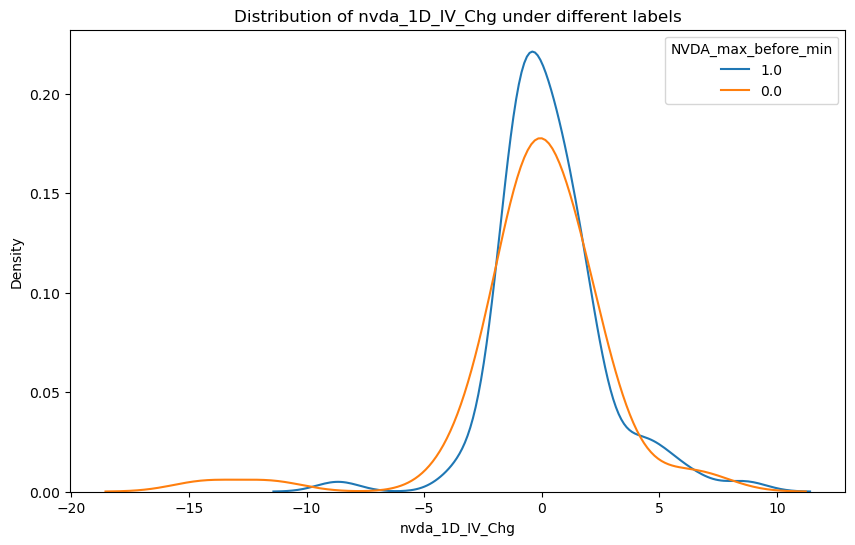

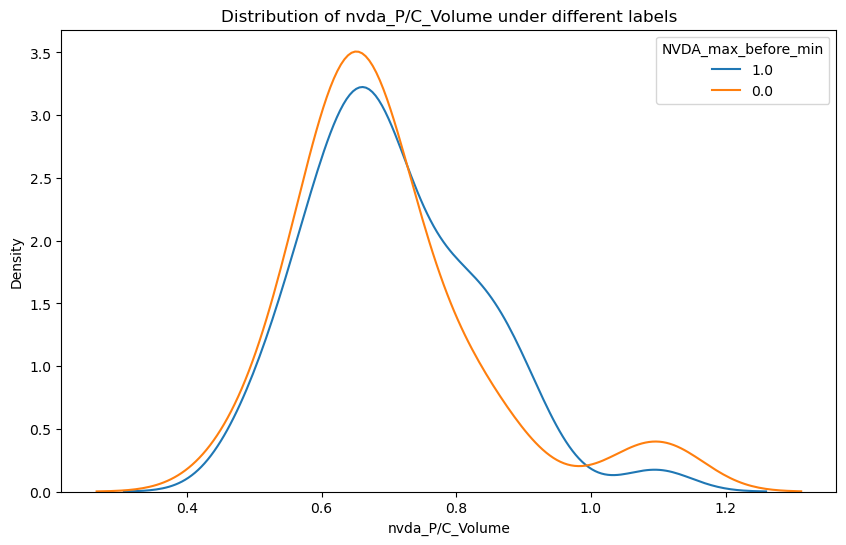

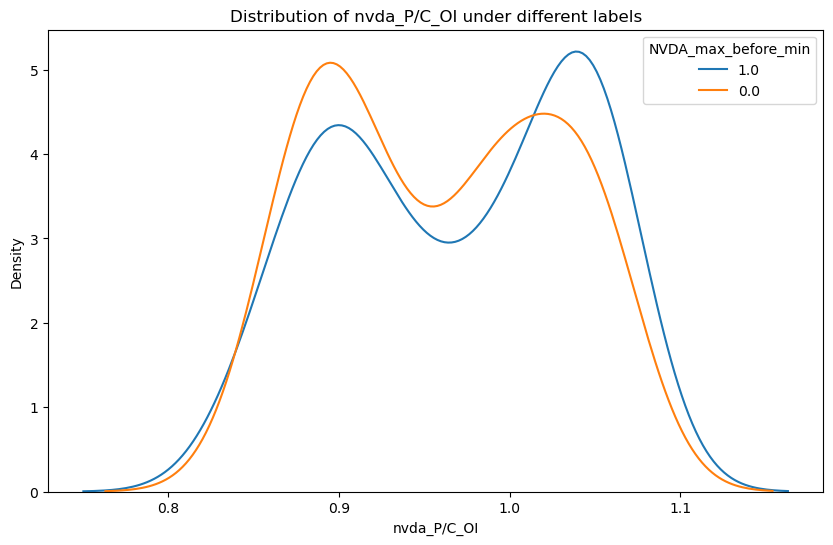

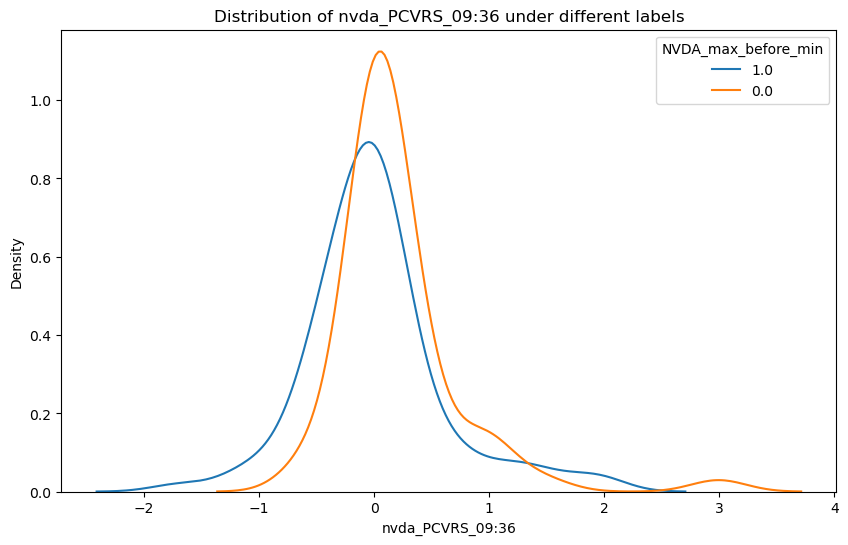

The KDE distribution of features under NVDA_price_increase:




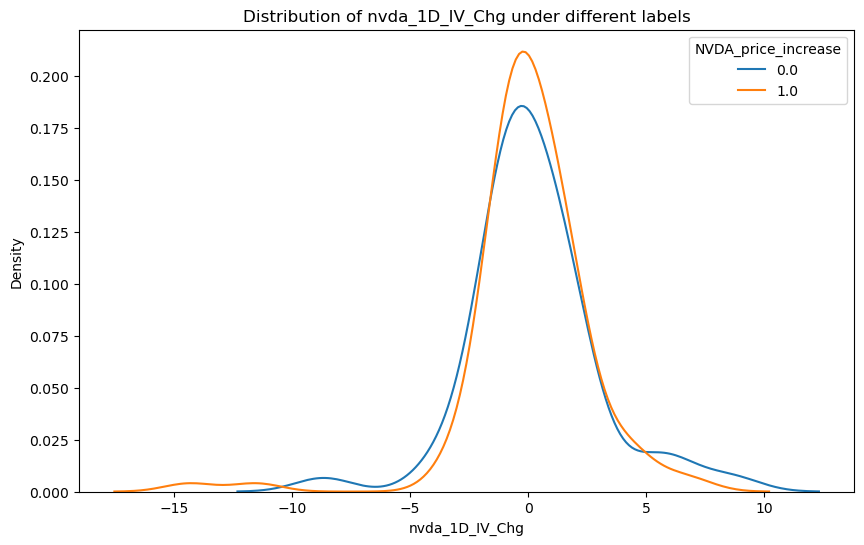

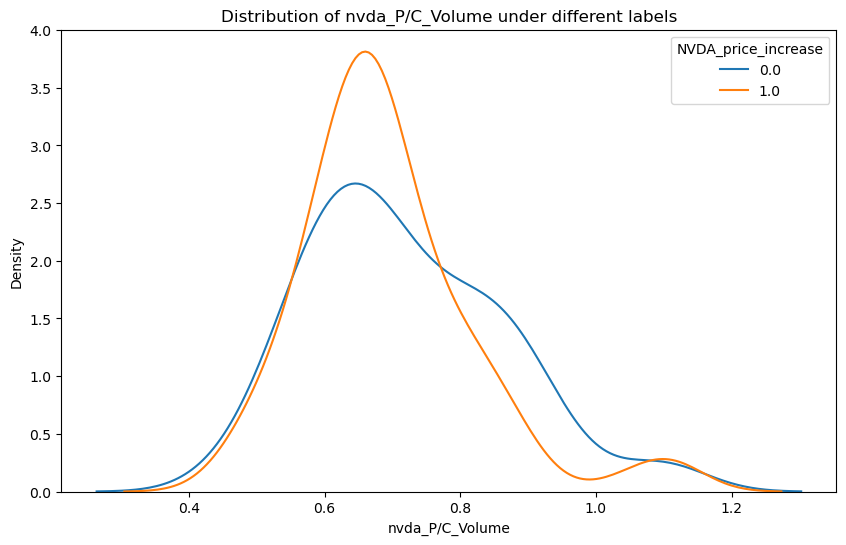

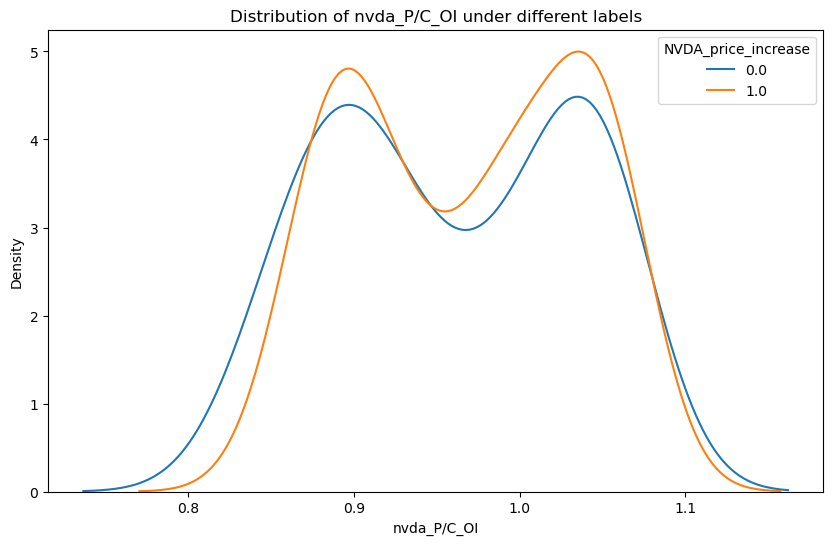

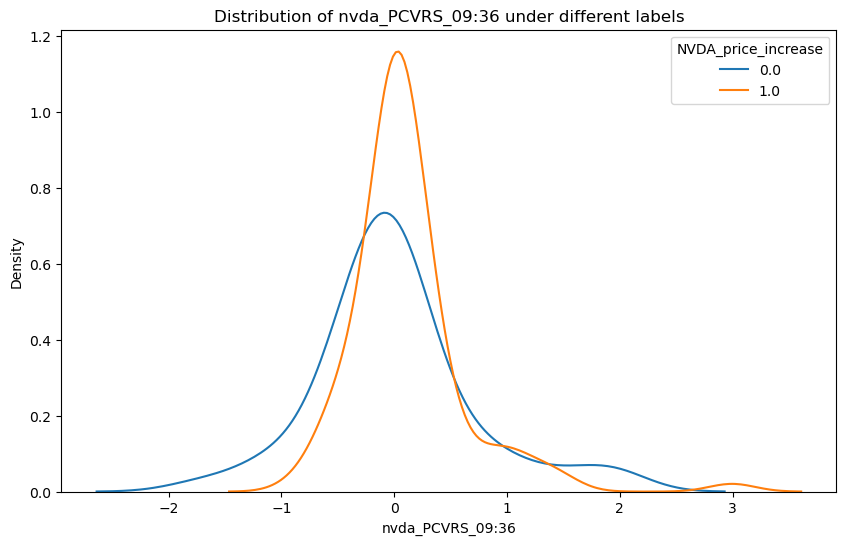

In [16]:
features_to_plot = ['nvda_1D_IV_Chg', 'nvda_P/C_Volume', 'nvda_P/C_OI','nvda_PCVRS_09:36']
labels_to_plot = ["NVDA_max_before_min",'NVDA_price_increase']
for i in range(2):
    print(f'The KDE distribution of features under {labels_to_plot[i]}:\n\n')
    
    for feature in features_to_plot:
        plt.figure(figsize=(10, 6))
        #sns.histplot(data=data, x=feature, hue=labels_to_plot[i], kde=False, element="step", stat="density", common_norm=False, palette="viridis", alpha=0.5)
        for label in data[labels_to_plot[i]].unique():
            sns.kdeplot(data=data[data[labels_to_plot[i]] == label], x=feature, label=label)
        plt.title(f'Distribution of {feature} under different labels')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend(title=labels_to_plot[i])
        plt.show()

Correlation Plot:

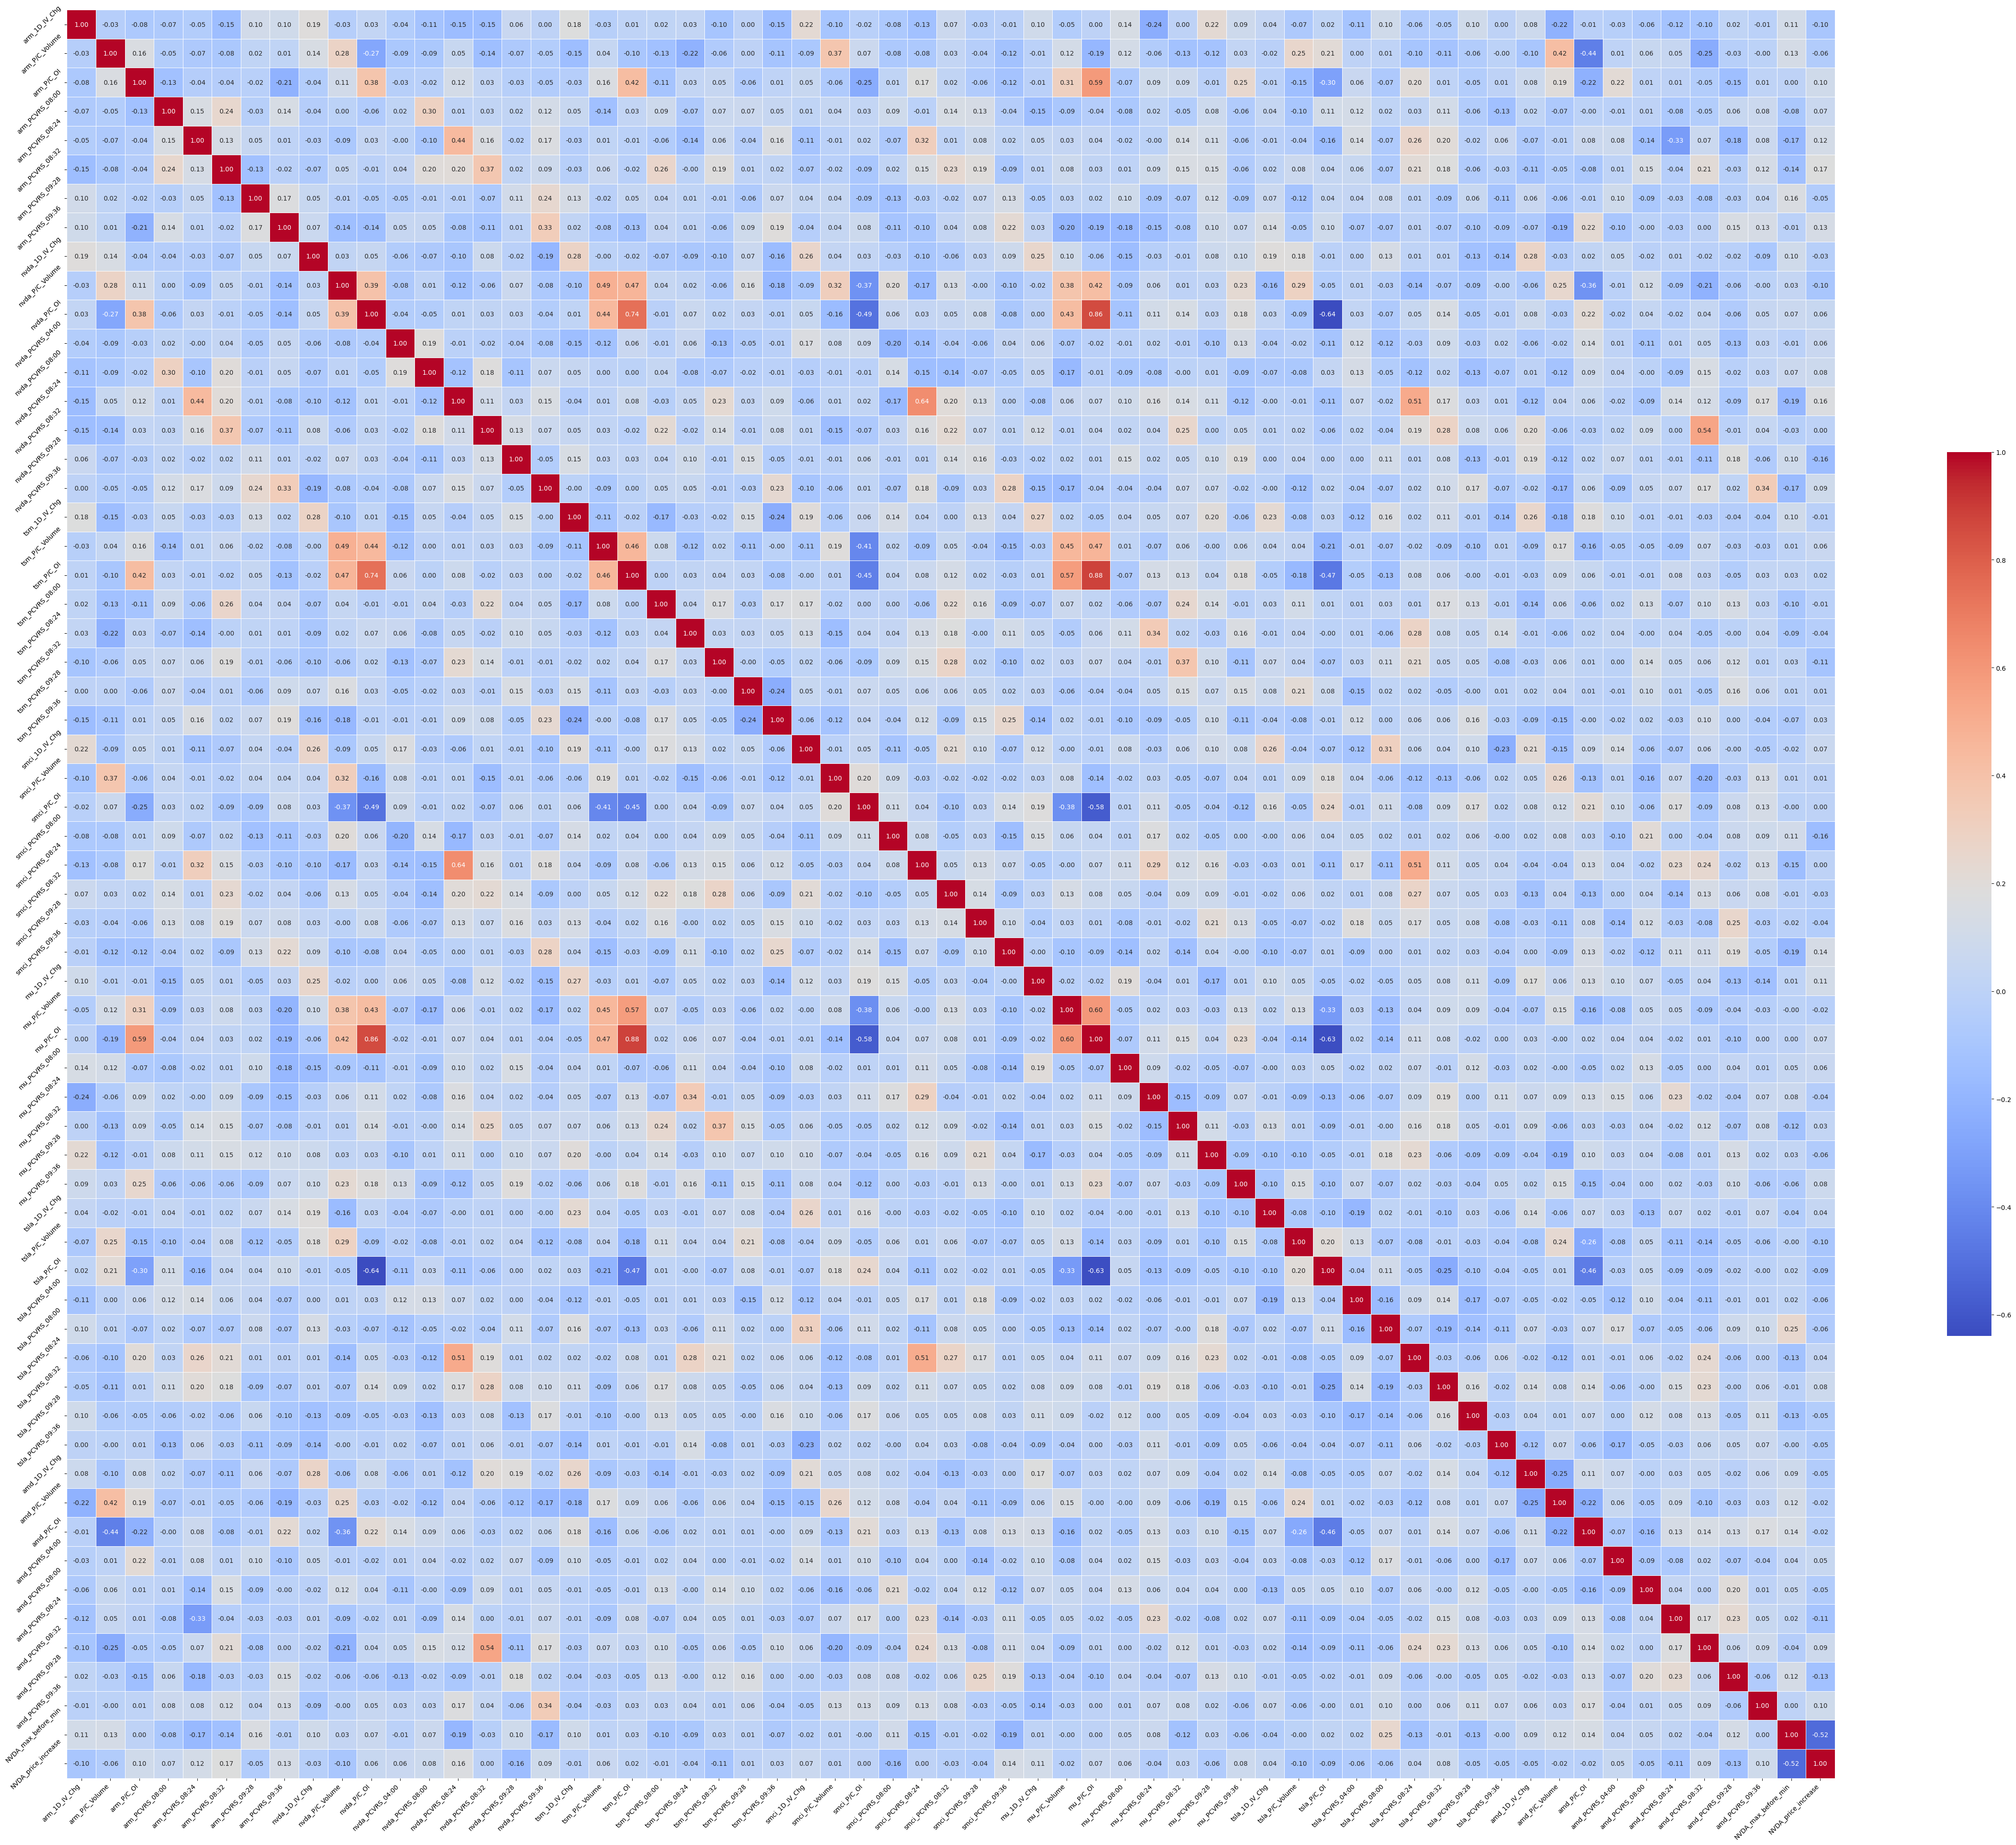

In [17]:
# correlation matrix of the columns of X_scaled
correlation_matrix = data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(50, 40))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Adjust layout to make room for the rotated x-axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

### 3. XGBoost

#### 3.1 XGBoost in classifying 'NVDA_max_before_min'

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.9}
Accuracy: 0.7222
Confusion Matrix:
[[ 8  8]
 [ 2 18]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.50      0.62        16
         1.0       0.69      0.90      0.78        20

    accuracy                           0.72        36
   macro avg       0.75      0.70      0.70        36
weighted avg       0.74      0.72      0.71        36



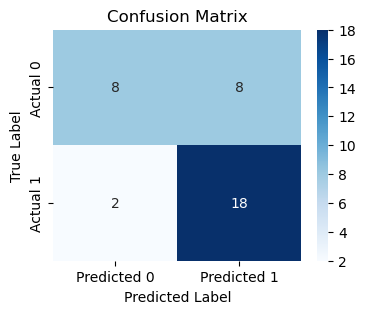

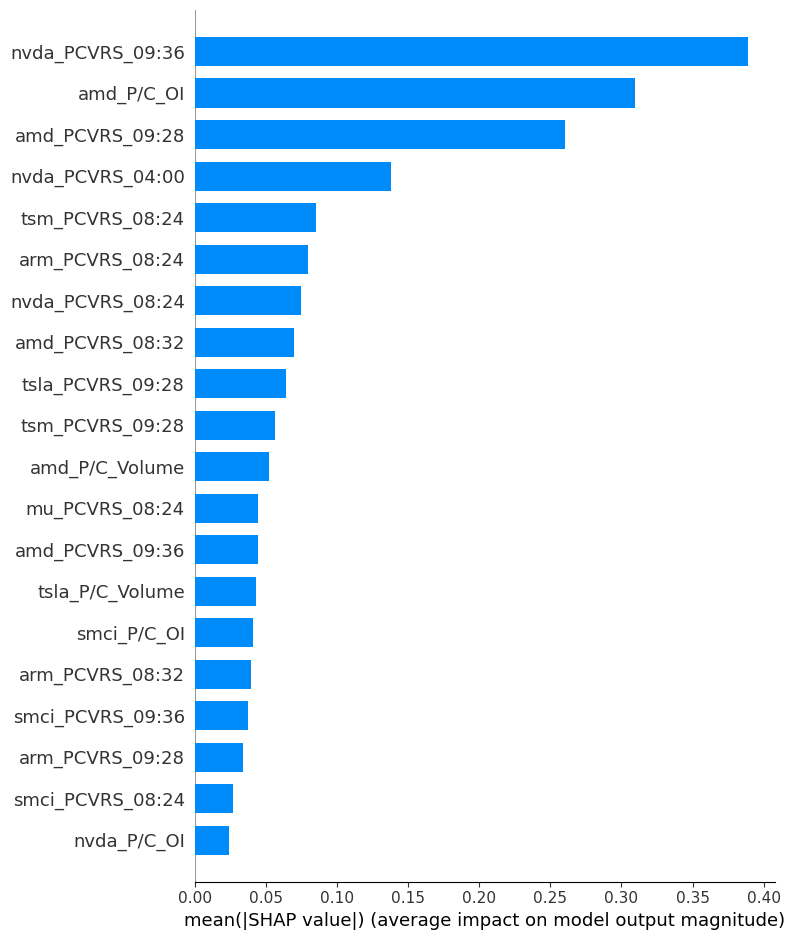

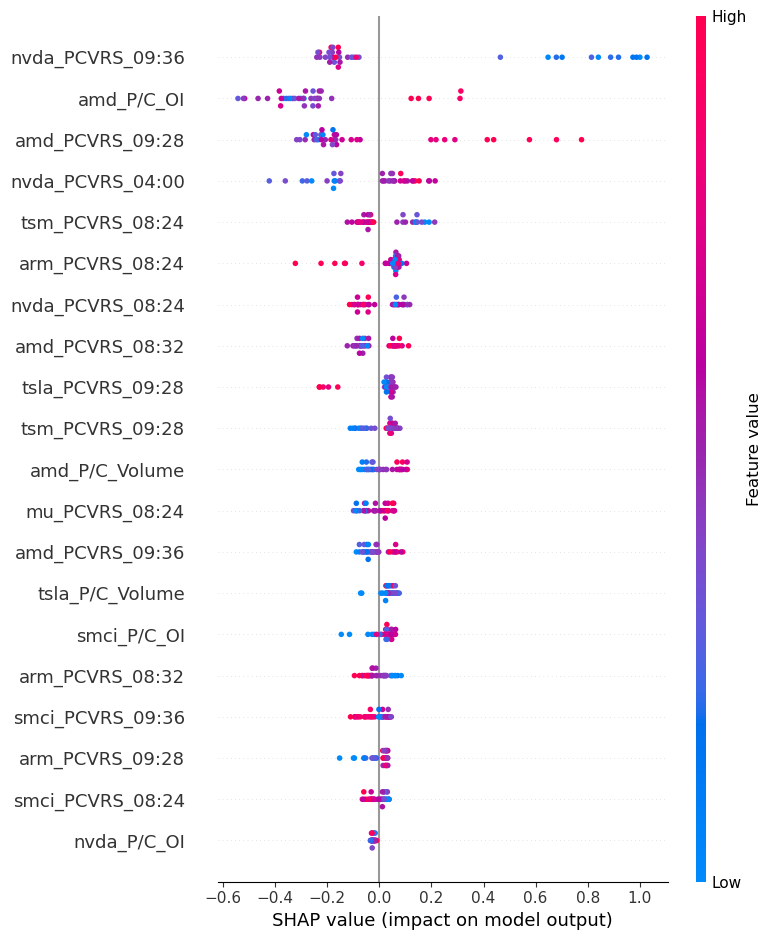

In [18]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Example data
df = data

# Split the data into features and target
X = df.drop(["NVDA_max_before_min", 'NVDA_price_increase'], axis=1)
y = df["NVDA_max_before_min"]

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame to retain column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Time series split
n_splits = 3  # Number of folds for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_scaled_df, y)

# Display the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_xgb = xgb.XGBClassifier(**best_params, objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Use the last split as the train-test split
train_index, test_index = list(tscv.split(X_scaled_df))[-1]
X_train, X_test = X_scaled_df.iloc[train_index], X_scaled_df.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Train the model
best_xgb.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

# Classification Report
class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

# Visualize the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# SHAP feature importance
explainer = shap.Explainer(best_xgb, X_train)
shap_values = explainer(X_test)

# Summary plot (bar)
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_train.columns, max_display=20)
plt.show()

# Summary plot (detailed)
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, max_display=20)
plt.show()


#### 3.2 XGBoost in classifying 'NVDA_price_increase'

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.9}
Accuracy: 0.6667
Confusion Matrix:
[[ 6  8]
 [ 4 18]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.43      0.50        14
         1.0       0.69      0.82      0.75        22

    accuracy                           0.67        36
   macro avg       0.65      0.62      0.62        36
weighted avg       0.66      0.67      0.65        36



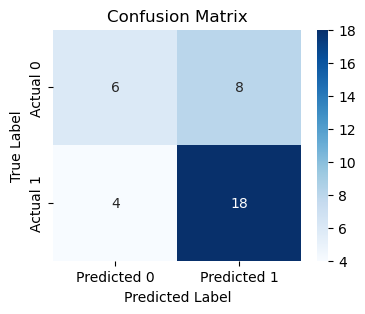

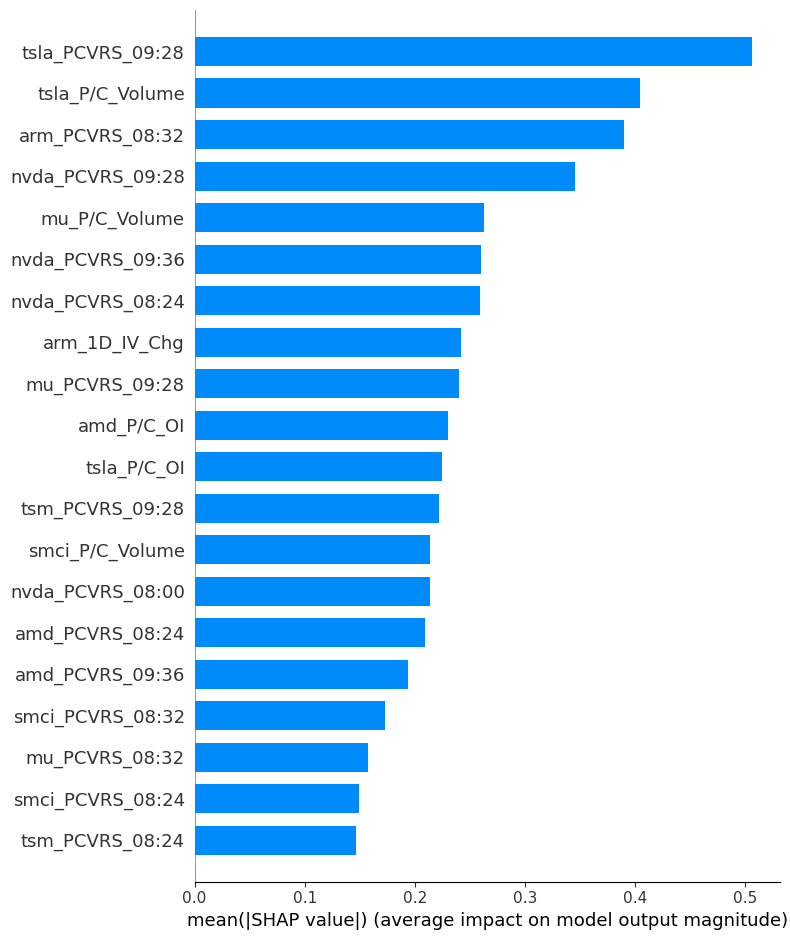

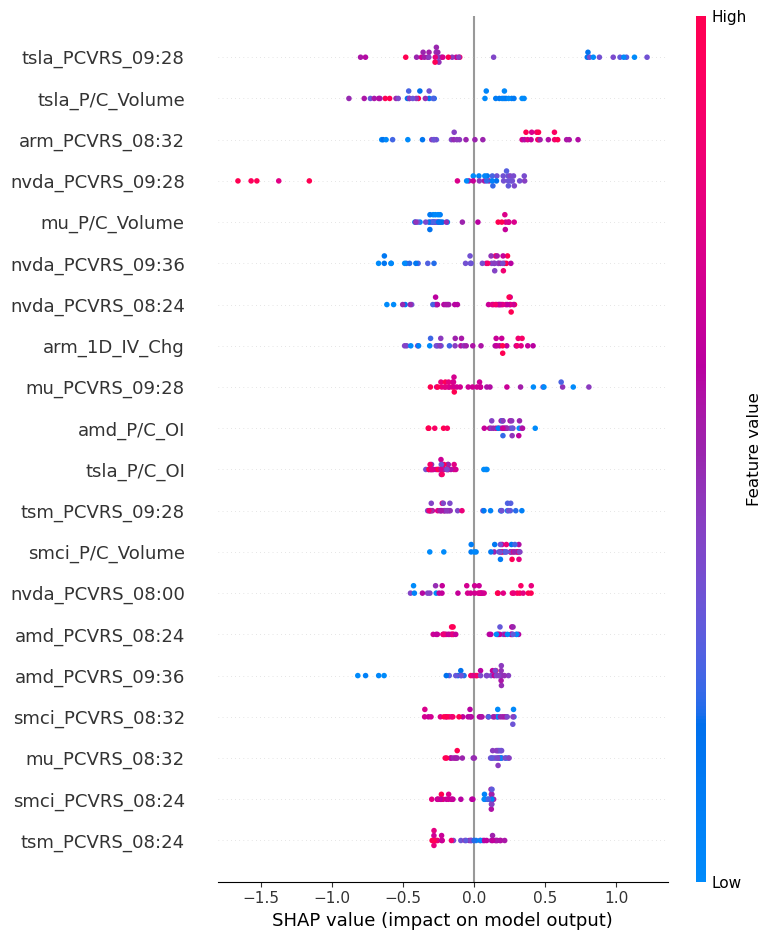

In [19]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Example data
df = data

# Split the data into features and target
X = df.drop(["NVDA_max_before_min", 'NVDA_price_increase'], axis=1)
y = df["NVDA_price_increase"]

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame to retain column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Time series split
n_splits = 3  # Number of folds for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=tscv, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_scaled_df, y)

# Display the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_xgb = xgb.XGBClassifier(**best_params, objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Use the last split as the train-test split
train_index, test_index = list(tscv.split(X_scaled_df))[-1]
X_train, X_test = X_scaled_df.iloc[train_index], X_scaled_df.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Train the model
best_xgb.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{conf_matrix}')

# Classification Report
class_report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{class_report}')

# Visualize the confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# SHAP feature importance
explainer = shap.Explainer(best_xgb, X_train)
shap_values = explainer(X_test)

# Summary plot (bar)
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_train.columns, max_display=20)
plt.show()

# Summary plot (detailed)
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, max_display=20)
plt.show()


### 4. GRU

#### 4.1 GRU in classifying 'NVDA_max_before_min'

Training with units=30, batch_size=16, epochs=50, optimizer=adam
2/2 [==============================] - 0s 1ms/step
Accuracy: 0.5278
Training with units=30, batch_size=16, epochs=50, optimizer=rmsprop
2/2 [==============================] - 0s 1ms/step
Accuracy: 0.5833
Training with units=30, batch_size=16, epochs=100, optimizer=adam
2/2 [==============================] - 0s 1ms/step
Accuracy: 0.6111
Training with units=30, batch_size=16, epochs=100, optimizer=rmsprop
2/2 [==============================] - 0s 1ms/step
Accuracy: 0.5278
Training with units=30, batch_size=32, epochs=50, optimizer=adam
2/2 [==============================] - 0s 959us/step
Accuracy: 0.5278
Training with units=30, batch_size=32, epochs=50, optimizer=rmsprop
2/2 [==============================] - 0s 1ms/step
Accuracy: 0.5556
Training with units=30, batch_size=32, epochs=100, optimizer=adam
2/2 [==============================] - 0s 1ms/step
Accuracy: 0.5556
Training with units=30, batch_size=32, epochs=100, opti

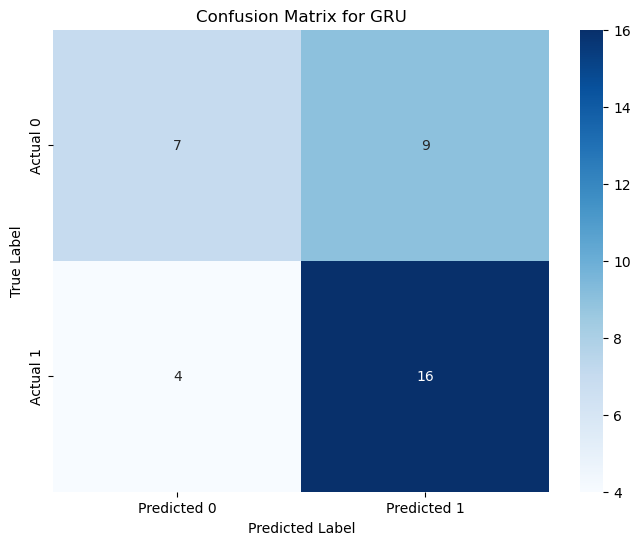

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

df = data
# Split the data into features and target
X = df.drop(["NVDA_max_before_min", 'NVDA_price_increase'], axis=1)
y = df["NVDA_max_before_min"]

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Time series split
n_splits = 3  # Number of folds for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

# Use the last split as the train-test split
train_index, test_index = list(tscv.split(X))[-1]
X_train, X_test = X_scaled[train_index], X_scaled[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Reshape data for GRU
X_train_gru = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_gru = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Convert labels to categorical
num_classes = len(np.unique(y))
y_train_gru = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_gru = tf.keras.utils.to_categorical(y_test, num_classes)

# Function to create the GRU model
def create_gru_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(units=units, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=num_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter grid
param_grid = {
    'units': [30, 50, 70],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100],
    'optimizer': ['adam', 'rmsprop']
}

# Manual hyperparameter search
best_accuracy = 0
best_params = None
best_model = None

for units in param_grid['units']:
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            for optimizer in param_grid['optimizer']:
                print(f"Training with units={units}, batch_size={batch_size}, epochs={epochs}, optimizer={optimizer}")

                model = create_gru_model(units=units, optimizer=optimizer)
                model.fit(X_train_gru, y_train_gru, epochs=epochs, batch_size=batch_size, verbose=0)

                # Make predictions
                y_pred_gru_prob = model.predict(X_test_gru)
                y_pred_gru = np.argmax(y_pred_gru_prob, axis=1)
                y_true = np.argmax(y_test_gru, axis=1)

                # Evaluate the model
                accuracy = accuracy_score(y_true, y_pred_gru)
                print(f"Accuracy: {accuracy:.4f}")

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {'units': units, 'batch_size': batch_size, 'epochs': epochs, 'optimizer': optimizer}
                    best_model = model

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Make final predictions with the best model
y_pred_gru_prob = best_model.predict(X_test_gru)
y_pred_gru = np.argmax(y_pred_gru_prob, axis=1)
y_true = np.argmax(y_test_gru, axis=1)

# Evaluate the model
accuracy_gru = accuracy_score(y_true, y_pred_gru)
print(f'Final GRU Accuracy: {accuracy_gru:.4f}')

# Confusion Matrix
conf_matrix_gru = confusion_matrix(y_true, y_pred_gru)
print(f'Confusion Matrix for GRU:\n{conf_matrix_gru}')

# Explicitly define positive label as class 1
class_report_gru = classification_report(y_true, y_pred_gru, target_names=['Class 0', 'Class 1'])
print(f'Classification Report for GRU:\n{class_report_gru}')

# Visualize the confusion matrix for GRU
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gru, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for GRU')
plt.show()

#### 4.2 GRU in classifying 'NVDA_price_increase'

Training with units=30, batch_size=16, epochs=50, optimizer=adam
2/2 [==============================] - 0s 1ms/step
Accuracy: 0.6111
Training with units=30, batch_size=16, epochs=50, optimizer=rmsprop
2/2 [==============================] - 0s 1ms/step
Accuracy: 0.6389
Training with units=30, batch_size=16, epochs=100, optimizer=adam
2/2 [==============================] - 0s 1ms/step
Accuracy: 0.5000
Training with units=30, batch_size=16, epochs=100, optimizer=rmsprop
2/2 [==============================] - 0s 1ms/step
Accuracy: 0.5833
Training with units=30, batch_size=32, epochs=50, optimizer=adam
2/2 [==============================] - 0s 1ms/step
Accuracy: 0.6111
Training with units=30, batch_size=32, epochs=50, optimizer=rmsprop
2/2 [==============================] - 0s 1ms/step
Accuracy: 0.6111
Training with units=30, batch_size=32, epochs=100, optimizer=adam
2/2 [==============================] - 0s 1ms/step
Accuracy: 0.5556
Training with units=30, batch_size=32, epochs=100, optimi

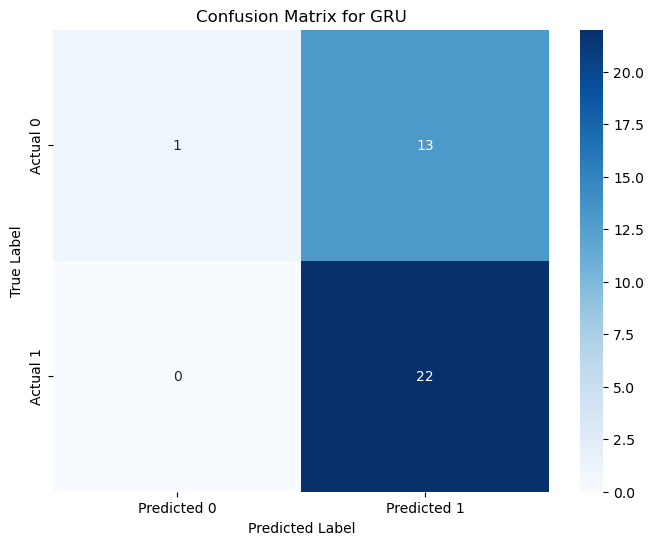

In [21]:


df = data
# Split the data into features and target
X = df.drop(["NVDA_max_before_min", 'NVDA_price_increase'], axis=1)
y = df["NVDA_price_increase"]

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Time series split
n_splits = 3  # Number of folds for cross-validation
tscv = TimeSeriesSplit(n_splits=n_splits)

# Use the last split as the train-test split
train_index, test_index = list(tscv.split(X))[-1]
X_train, X_test = X_scaled[train_index], X_scaled[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Reshape data for GRU
X_train_gru = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_gru = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Convert labels to categorical
num_classes = len(np.unique(y))
y_train_gru = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_gru = tf.keras.utils.to_categorical(y_test, num_classes)

# Function to create the GRU model
def create_gru_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train_gru.shape[1], X_train_gru.shape[2])))
    model.add(Dropout(0.2))
    model.add(GRU(units=units, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=num_classes, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter grid
param_grid = {
    'units': [30, 50, 70],
    'batch_size': [16, 32, 64],
    'epochs': [50, 100],
    'optimizer': ['adam', 'rmsprop']
}

# Manual hyperparameter search
best_accuracy = 0
best_params = None
best_model = None

for units in param_grid['units']:
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            for optimizer in param_grid['optimizer']:
                print(f"Training with units={units}, batch_size={batch_size}, epochs={epochs}, optimizer={optimizer}")

                model = create_gru_model(units=units, optimizer=optimizer)
                model.fit(X_train_gru, y_train_gru, epochs=epochs, batch_size=batch_size, verbose=0)

                # Make predictions
                y_pred_gru_prob = model.predict(X_test_gru)
                y_pred_gru = np.argmax(y_pred_gru_prob, axis=1)
                y_true = np.argmax(y_test_gru, axis=1)

                # Evaluate the model
                accuracy = accuracy_score(y_true, y_pred_gru)
                print(f"Accuracy: {accuracy:.4f}")

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {'units': units, 'batch_size': batch_size, 'epochs': epochs, 'optimizer': optimizer}
                    best_model = model

print(f"Best Parameters: {best_params}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Make final predictions with the best model
y_pred_gru_prob = best_model.predict(X_test_gru)
y_pred_gru = np.argmax(y_pred_gru_prob, axis=1)
y_true = np.argmax(y_test_gru, axis=1)

# Evaluate the model
accuracy_gru = accuracy_score(y_true, y_pred_gru)
print(f'Final GRU Accuracy: {accuracy_gru:.4f}')

# Confusion Matrix
conf_matrix_gru = confusion_matrix(y_true, y_pred_gru)
print(f'Confusion Matrix for GRU:\n{conf_matrix_gru}')

# Explicitly define positive label as class 1
class_report_gru = classification_report(y_true, y_pred_gru, target_names=['Class 0', 'Class 1'])
print(f'Classification Report for GRU:\n{class_report_gru}')

# Visualize the confusion matrix for GRU
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gru, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for GRU')
plt.show()